In [ ]:
# Copyright (c) 2025, ETH Zurich

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
import scipy.signal as scis

In [4]:
# physics
"Transfer function for the Fresnel free propagation."
def H(fx, fy, wl, z): 
    return np.exp(1j * 2 * np.pi / wl * z) * np.exp(-1j * np.pi * wl * z * (fx**2 + fy**2))

# gratings
def rectgrating(x, m, p, th = 0): 
    return 0.5*(1 + m * np.sign(np.cos(2 * np.pi * x / p) - th))

def nextbase(base, number):
    numerator = 0
    i = 0
    while (numerator < number):
        numerator = base ** i
        i+=1
        
    return numerator

def fresnelgrid(dx = 0.1e-6, dy = 0.1e-6, Nx = 2000, Ny = 2000, efficient = True):
    if efficient:
        # FFTs are faster on arrays of lengths equal to powers of 2
        Nx = nextbase(2, Nx)
        Ny = nextbase(2, Ny)
    # x are columns, y are rows
    Nx_ar = np.linspace(1, Nx, Nx)
    Ny_ar = np.linspace(1, Ny, Ny)
    x = dx * (Nx_ar - Nx/2)
    y = dy * (Ny_ar - Ny/2)

    fx = (np.fft.fftfreq(len(x)) / dx)
    fy = (np.fft.fftfreq(len(y)) / dy)

    return x, y, fx, fy

tonormalspace = lambda U, fourier_axis=1: sp.fft.ifft(U, axis=fourier_axis)
tofourierspace = lambda u, fourier_axis=1: sp.fft.fft(u, axis=fourier_axis)
flatwave = lambda x, y: np.ones((len(y), len(x)))

"Propagate a wavefront in the Fourier space"
def propagate_shaped(U, fx, fy, wl, z, func = H): 
    return U * H(fx, fy, wl, z)

# This one leads to minor array conflicts for some reason only AFTER backtransformation for whatever reason
def propagate(U, fx, fy, wl, z, func = H): 
    exceptk = 0
    try:
        loop_i=len(fy)
    except:
        loop_i=1
    try:
        loop_j=len(fx)
    except:
        loop_j=1
    try:
        loop_k=len(z)
    except:
        loop_k=1
        exceptk=1
    sol=np.zeros((loop_i, loop_j, loop_k))
    print(U.shape, fx.shape, z, sol.shape)
    for i in range(loop_i):
        for j in range(loop_j):
            for k in range(loop_k):
                if exceptk:
                    if H(fx[j], fy[i], wl, z) != 1:
                        print("Oh no: ", H(fx[j], fy[i], wl, z), ", variables: ", fx[j], fy[i], wl, z, " end")
                    sol[i,j,k] = U[i,j] * H(fx[j], fy[i], wl, z)
                else:
                    if H(fx[j], fy[i], wl, z[k]) != 1:
                        print("Oh no: ", H(fx[j], fy[i], wl, z[k]), ", variables: ", fx[j], fy[i], wl, z[k], " end")
                    sol[i,j,k] = U[i,j] * H(fx[j], fy[i], wl, z[k])
    return sol


def propagatenormal(u, fx, fy, wl, z, fourier_axis0=1, fourier_axis1=1, func = H):
    return tonormalspace(propagate_shaped(tofourierspace(u, fourier_axis0), fx, fy, wl, z, func), fourier_axis1)

h = 6.62607004 * 10**(-34) # planck constant in mˆ2 kg / s
c_0 = 299792458 # speed of light in m / s
eV_to_joule = 1.602176634*10**(-19)

dbagrating = lambda x, y, p1, p2: rectgrating(x, y, p1, 0) * rectgrating(x, y, p2, 0)

In [5]:
def bin_me_res(data, x_axis, new_dx, axis=-2):
    """
    data must have dimensions:
    [x, z]
    """
    if axis!=-2:
        data = np.swapaxes(data, axis, -2)
    dx = abs(x_axis[1]-x_axis[0])
    binning = int(new_dx/dx)
    bin_range= int(data.shape[-2]/binning)
    if binning<2:
        print("no binnin necessary")
        return data
    sol = np.zeros((*data.shape[:-2],int(data.shape[-2]/binning),data.shape[-1]))
    new_x_grid = []
    for i in range(bin_range):
        sol[...,i,:] = np.sum(data[...,i*binning:(i+1)*binning,:], axis=-2)#[:,np.newaxis, :]
        new_x_grid.append(x_axis[...,i*binning+int(binning/2)])
    if axis!=-2:
        sol = np.swapaxes(sol, -2, axis)
    return sol, np.asarray(new_x_grid)

In [6]:
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str, fontsize=18, on_frame=False):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', fontsize=fontsize)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [7]:
def composite_dba_2rd_order(p_m1, P, dx):
    dx_ = dx-P/2
    dba = np.zeros_like(dx)
    dba_m1 = dbagrating(dx, 1, P, p_m1)
    dba_m3 = dbagrating(dx, 1, P, p_m1/3)
    
    for i in range(len(dx)):
        if (int(abs(dx_[i])/(P)) % 4 == 0) or (int(abs(dx_[i])/(P)) % 4 == 3):
            dba[i]=dba_m1[i]+0.331
        elif (int(abs(dx_[i])/(P)) % 4 == 1) or (int(abs(dx_[i])/(P)) % 4 == 2):
            dba[i]=dba_m3[i]+0.47
        else:
            print(i)
    return dba

8.700645362362964e-07
(1, 131072)
(1, 131072)


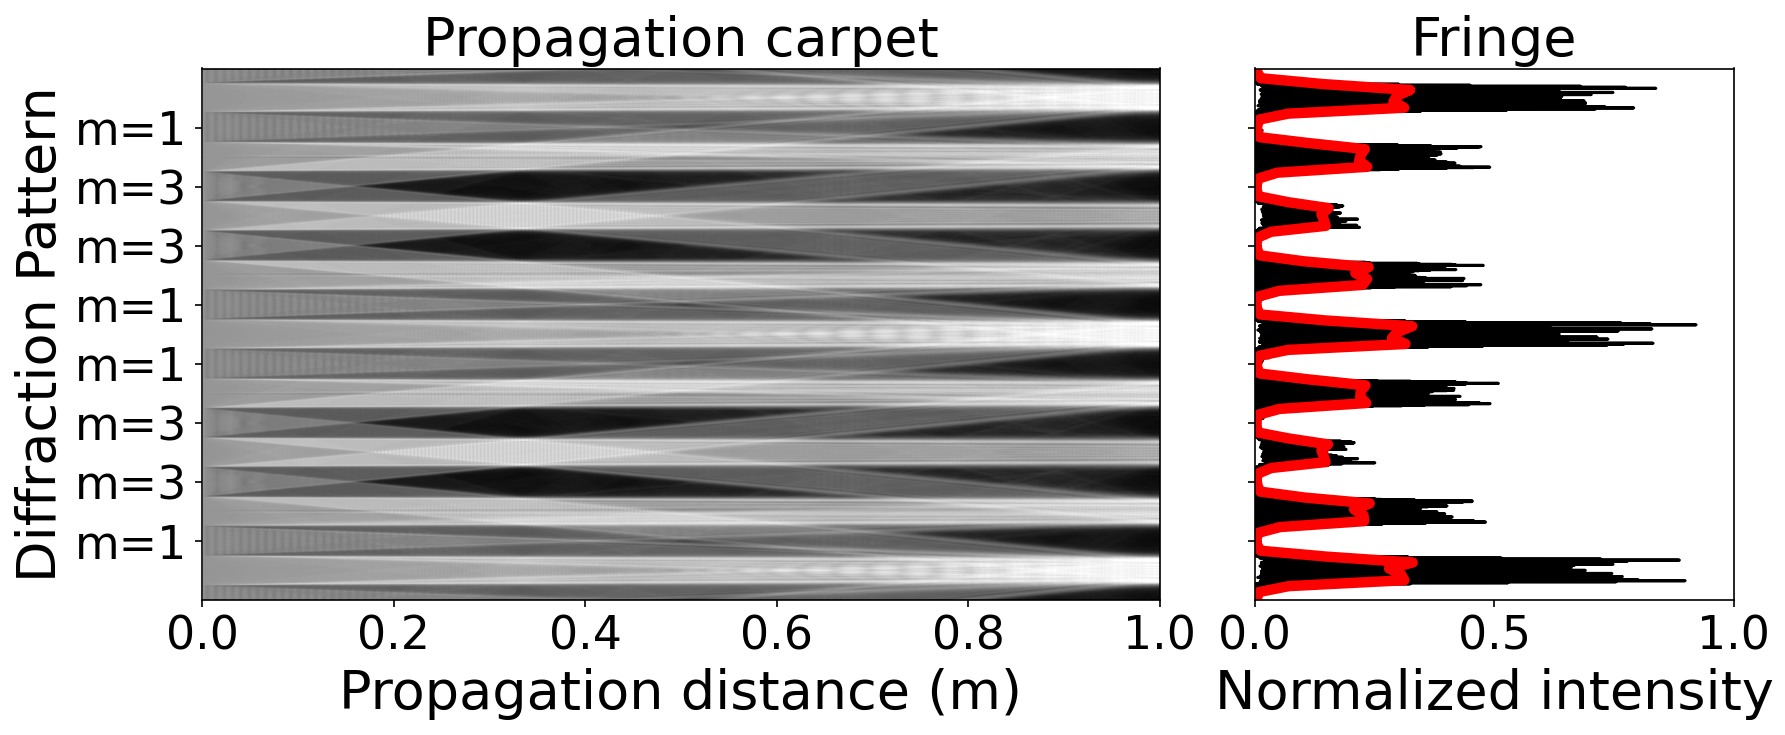

In [8]:

system_length = 1 #m
fringe_size = 50e-6 #m -> 250 mum
energy = 57000*eV_to_joule #joule -> 46keV
order=1
wl = h * c_0 / energy
P = fringe_size
p = wl/np.sin(np.arctan(order*P/2/system_length)) #m -> 1 mum
print(p)

dphi = np.pi

dx = 2e-8 #m -> 0.1 mum
d_x, d_y, d_fx, d_fy = fresnelgrid(dx = dx, dy = dx, Nx = 100000, Ny = 1)
g1 = np.exp(-1j * dphi * composite_dba_2rd_order(p, P, d_x)[np.newaxis, :])
print(g1.shape)

u1 = flatwave(d_x, d_y) * g1

#u2(z) = propagatenormal(u1, pp, λ, z)


z = np.linspace(0, 1, 1000)[np.newaxis,np.newaxis,:]
print(u1.shape)

talbot_carpet = abs(propagatenormal(u1[...,np.newaxis], d_fx[np.newaxis,:,np.newaxis], d_fy[:,np.newaxis,np.newaxis], wl, z))**2
l1=0
display_gamma = 0.7

font_size=26
fig, axs = plt.subplots(ncols=2, nrows=1, sharey=True, sharex=False, gridspec_kw=dict(width_ratios = [2, 1]), figsize=(12,5), dpi=150)

axs[0].set_title("Propagation carpet", fontsize=font_size)
axs[1].set_title("Fringe", fontsize=font_size)
axs[0].imshow(talbot_carpet[0, :, :]**display_gamma,
    interpolation = "bicubic",
    origin="lower",
    extent=[
        l1 + z[0,0,1], # left
        l1 + z[0,0,-1], # right
        d_x[1]*1e3, # bottom
        d_x[-1]*1e3 # top
        ],
    aspect="auto",
    cmap="Greys_r",
    vmax=2)

index_m = ["m=1", "m=3", "m=3","m=1","m=1", "m=3", "m=3", "m=1"]
x_positions = np.arange(len(index_m))*P-3*P
plt.yticks(x_positions*1e3, index_m)

axs[0].set_ylabel("Diffraction Pattern", fontsize=font_size)
axs[0].set_ylim(-P*4e3, P*5e3)
axs[0].set_xlim(0, 1)

fringe_bin, x_bin = bin_me_res(talbot_carpet[0, :, -1:], d_x, 5e-6, axis=-2)

axs[1].plot(talbot_carpet[0, :, -1]/talbot_carpet[0, :, -1].max(), d_x*1e3, color="black")
axs[1].plot(fringe_bin/fringe_bin.max()/3, x_bin*1e3, lw=5, color="red")
axs[1].set_ylim(-P*4e3, P*5e3)
axs[1].set_xlim(0, 1)

axs[0].set_xlabel("Propagation distance (m)", fontsize=font_size)
axs[1].set_xlabel("Normalized intensity", fontsize=font_size)

axs[0].yaxis.set_tick_params(labelsize=font_size-4)
axs[0].xaxis.set_tick_params(labelsize=font_size-4)
axs[1].xaxis.set_tick_params(labelsize=font_size-4)

fig.tight_layout()

8.700645362362964e-07
(1, 131072)
(1, 131072)
2.9002151280381926e-07
(1, 131072)
(1, 131072)


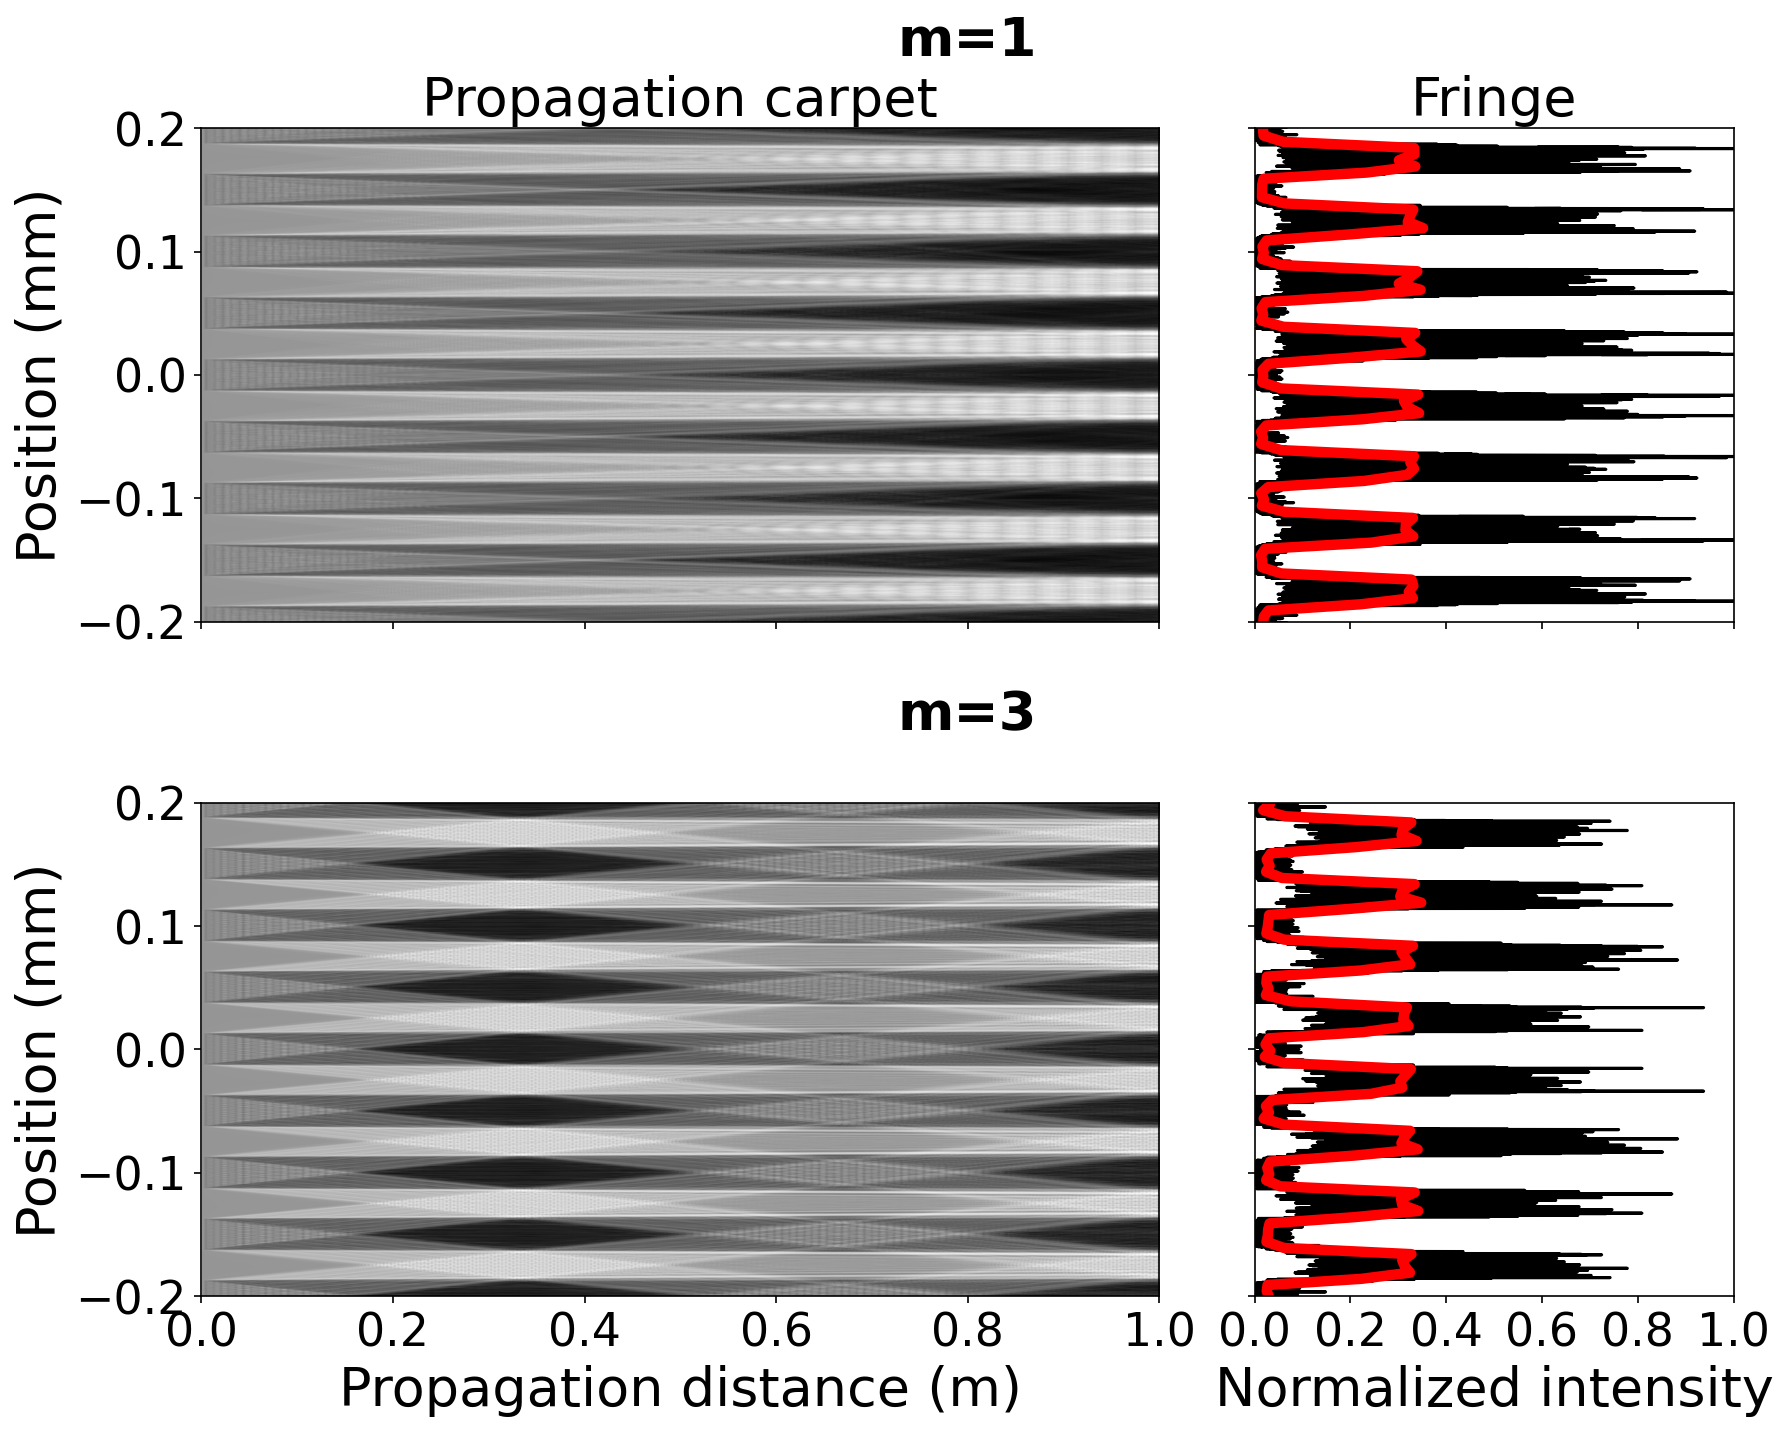

In [9]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True, sharex=True, gridspec_kw=dict(width_ratios = [2, 1]), figsize=(12,10), dpi=150)
l1=0

font_size = 26

system_length = 1 #m
fringe_size = 50e-6 #m -> 250 mum
energy = 57000*eV_to_joule #joule -> 46keV
order=1
wl = h * c_0 / energy
P = fringe_size
p = wl/np.sin(np.arctan(order*P/2/system_length)) #m -> 1 mum
print(p)

dphi = np.pi

dx = 1e-7 #m -> 0.1 mum
d_x, d_y, d_fx, d_fy = fresnelgrid(dx = dx, dy = dx, Nx = 100000, Ny = 1)
g1 = np.exp(-1j * dphi * dbagrating(d_x, np.ones_like(d_y)[:,np.newaxis], P, p))
print(g1.shape)

u1 = flatwave(d_x, d_y) * g1

#u2(z) = propagatenormal(u1, pp, λ, z)


z = np.linspace(0, 1, 2000)[np.newaxis,np.newaxis,:]
print(u1.shape)

talbot_carpet = abs(propagatenormal(u1[...,np.newaxis], d_fx[np.newaxis,:,np.newaxis], d_fy[:,np.newaxis,np.newaxis], wl, z))**2
l1=0
display_gamma = 0.7

grid = plt.GridSpec(2, 2)
create_subtitle(fig, grid[0, ::], 'm=1', fontsize=font_size)
create_subtitle(fig, grid[1, ::], 'm=3', on_frame=True, fontsize=font_size)

ax=axs[0,:]
ax[0].set_title("Propagation carpet", fontsize=font_size)
ax[1].set_title("Fringe", fontsize=font_size)
ax[0].imshow(talbot_carpet[0, :, :]**display_gamma,
    interpolation = "bicubic",
    origin="lower",
    extent=[
        l1 + z[0,0,1], # left
        l1 + z[0,0,-1], # right
        d_x[1]*1e3, # bottom
        d_x[-1]*1e3 # top
        ],
    aspect="auto",
    cmap="Greys_r",
    vmax=2)

# axs[0].axvline(2.7, color="C0")
# axs[0].axvline(optimal_distance_pb, color="C1")



# ax[0].set_xlabel("z position in m")
ax[0].set_ylabel("Position (mm)", fontsize=font_size)
ax[0].set_ylim(0.0002*1e3, -0.0002*1e3)
ax[0].set_xlim(0, 1)

fringe_bin, x_bin = bin_me_res(talbot_carpet[0, :, -1:], d_x, 5e-6, axis=-2)

ax[1].plot(talbot_carpet[0, :, -1]/6, d_x*1e3, color="black")
ax[1].plot(fringe_bin/50/6, x_bin*1e3, lw=5, color="red")
ax[1].set_ylim(-2e-4*1e3, 2e-4*1e3)

# ax[1].set_xlabel("Intensity")
# axs[1].set_ylabel("x position in m")



system_length = 1 #m
fringe_size = 50e-6 #m -> 250 mum
energy = 57000*eV_to_joule #joule -> 46keV
order=3
wl = h * c_0 / energy
P = fringe_size
p = wl/np.sin(np.arctan(order*P/2/system_length)) #m -> 1 mum
print(p)

dphi = np.pi

dx = 1e-7 #m -> 0.1 mum
d_x, d_y, d_fx, d_fy = fresnelgrid(dx = dx, dy = dx, Nx = 100000, Ny = 1)
g1 = np.exp(-1j * dphi * dbagrating(d_x, np.ones_like(d_y)[:,np.newaxis], P, p))
print(g1.shape)

u1 = flatwave(d_x, d_y) * g1

#u2(z) = propagatenormal(u1, pp, λ, z)


z = np.linspace(0, 1, 2000)[np.newaxis,np.newaxis,:]
print(u1.shape)

talbot_carpet = abs(propagatenormal(u1[...,np.newaxis], d_fx[np.newaxis,:,np.newaxis], d_fy[:,np.newaxis,np.newaxis], wl, z))**2

l1=0
display_gamma = 0.7
ax=axs[1,:]
ax[0].imshow(talbot_carpet[0, :, :]**display_gamma,
    interpolation = "bicubic",
    origin="lower",
    extent=[
        l1 + z[0,0,1], # left
        l1 + z[0,0,-1], # right
        d_x[1]*1e3, # bottom
        d_x[-1]*1e3 # top
        ],
    aspect="auto",
    cmap="Greys_r",
    vmax=2)

# axs[0].axvline(2.7, color="C0")
# axs[0].axvline(optimal_distance_pb, color="C1")



ax[0].set_xlabel("Propagation distance (m)", fontsize=font_size)
ax[0].set_ylabel("Position (mm)", fontsize=font_size)
ax[0].set_ylim(0.0002*1e3, -0.0002*1e3)
ax[0].set_xlim(0, 1)

fringe_bin, x_bin = bin_me_res(talbot_carpet[0, :, -1:], d_x, 5e-6, axis=-2)

ax[1].plot(talbot_carpet[0, :, -1]/6, d_x*1e3, color="black")
ax[1].plot(fringe_bin/50/6, x_bin*1e3, lw=5, color="red")
ax[1].set_ylim(-2e-4*1e3, 2e-4*1e3)

ax[1].set_xlabel("Normalized intensity", fontsize=font_size)
# axs[1].set_ylabel("x position in m")

axs[0,0].yaxis.set_tick_params(labelsize=font_size-4)
axs[0,1].yaxis.set_tick_params(labelsize=font_size-4)
axs[1,0].yaxis.set_tick_params(labelsize=font_size-4)
axs[1,1].yaxis.set_tick_params(labelsize=font_size-4)
axs[1,0].xaxis.set_tick_params(labelsize=font_size-4)
axs[1,1].xaxis.set_tick_params(labelsize=font_size-4)

plt.tight_layout()